In [66]:
from __future__ import print_function
from keras.layers import Convolution1D, MaxPooling1D
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import CSVLogger
from keras.layers import LSTM
from keras import callbacks
from keras.layers import Convolution1D, Dense, Dropout, MaxPooling1D
from sklearn.preprocessing import Normalizer
import pandas as pd
from keras.layers import Dense, Dropout
from keras.models import Sequential
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(1337)  # for reproducibility

In [2]:
col_names = [
    'sport', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
    'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz',
    'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
    'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
    'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
    'Label'
]

In [3]:
def castNumeric(item):
    if item.isnumeric():
        return int(item)
    return np.nan

In [6]:
TRAIN_FILE = glob.glob('./csv_fold/fold*.csv')

In [7]:
TRAIN_FILE

['./csv_fold\\fold_0.csv',
 './csv_fold\\fold_1.csv',
 './csv_fold\\fold_10.csv',
 './csv_fold\\fold_11.csv',
 './csv_fold\\fold_12.csv',
 './csv_fold\\fold_13.csv',
 './csv_fold\\fold_14.csv',
 './csv_fold\\fold_15.csv',
 './csv_fold\\fold_16.csv',
 './csv_fold\\fold_17.csv',
 './csv_fold\\fold_18.csv',
 './csv_fold\\fold_19.csv',
 './csv_fold\\fold_2.csv',
 './csv_fold\\fold_20.csv',
 './csv_fold\\fold_21.csv',
 './csv_fold\\fold_3.csv',
 './csv_fold\\fold_4.csv',
 './csv_fold\\fold_5.csv',
 './csv_fold\\fold_6.csv',
 './csv_fold\\fold_7.csv',
 './csv_fold\\fold_8.csv',
 './csv_fold\\fold_9.csv']

In [8]:
TEST_FILE = glob.glob('./csv_fold/test.csv')

In [43]:
def load_csv(name):
    df = pd.read_csv(name, header=None, names=col_names,converters={'ct_ftp_cmd':castNumeric}, low_memory=False,)
    df = df.iloc[1:]
    df = df[~((df['is_sm_ips_ports'] == 0)|(df['is_sm_ips_ports'] == 1))]
    df = df[~((df['is_ftp_login'] == 0)|(df['is_ftp_login'] == 1))]
    df = df[~((df['Label'] == 0)|(df['Label'] == 1))]
    return df

In [44]:
load_csv(TRAIN_FILE[0]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sport             100000 non-null  object 
 1   dsport            100000 non-null  object 
 2   proto             100000 non-null  object 
 3   state             100000 non-null  object 
 4   dur               100000 non-null  object 
 5   sbytes            100000 non-null  object 
 6   dbytes            100000 non-null  object 
 7   sttl              100000 non-null  object 
 8   dttl              100000 non-null  object 
 9   sloss             100000 non-null  object 
 10  dloss             100000 non-null  object 
 11  service           100000 non-null  object 
 12  Sload             100000 non-null  object 
 13  Dload             100000 non-null  object 
 14  Spkts             100000 non-null  object 
 15  Dpkts             100000 non-null  object 
 16  swin              10

In [38]:
traindata = []
for name in TRAIN_FILE:
    traindata.append(load_csv(name))
traindf = pd.concat(traindata)

In [39]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100000 entries, 1 to 100000
Data columns (total 44 columns):
 #   Column            Dtype  
---  ------            -----  
 0   sport             object 
 1   dsport            object 
 2   proto             object 
 3   state             object 
 4   dur               object 
 5   sbytes            object 
 6   dbytes            object 
 7   sttl              object 
 8   dttl              object 
 9   sloss             object 
 10  dloss             object 
 11  service           object 
 12  Sload             object 
 13  Dload             object 
 14  Spkts             object 
 15  Dpkts             object 
 16  swin              object 
 17  dwin              object 
 18  stcpb             object 
 19  dtcpb             object 
 20  smeansz           object 
 21  dmeansz           object 
 22  trans_depth       object 
 23  res_bdy_len       object 
 24  Sjit              object 
 25  Djit              object 
 26  Sintpkt        

In [45]:
traindf.head

<bound method NDFrame.head of         sport dsport proto state       dur sbytes dbytes sttl dttl sloss  ...  \
1        1390     53   udp   CON  0.001055    132    164   31   29     0  ...   
2       33661   1024   udp   CON  0.036133    528    304   31   29     0  ...   
3        1464     53   udp   CON  0.001119    146    178   31   29     0  ...   
4        3593     53   udp   CON  0.001209    132    164   31   29     0  ...   
5       49664     53   udp   CON  0.001169    146    178   31   29     0  ...   
...       ...    ...   ...   ...       ...    ...    ...  ...  ...   ...  ...   
99996    5551     25   tcp   FIN  0.036674  37262   3380   31   29    18  ...   
99997   60838    111   udp   CON  0.004771    568    320   31   29     0  ...   
99998    1665    143   tcp   FIN  0.044128   7816  14952   31   29    30  ...   
99999   63494     80   tcp   FIN  1.076023   1684  10168   31   29     3  ...   
100000  53128     25   tcp   FIN  0.070535  37262   3380   31   29    18  ...  

In [47]:
traindf.fillna(0, inplace=True)

In [48]:
traindf.isna().sum()

sport               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
Sload               0
Dload               0
Spkts               0
Dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
Sjit                0
Djit                0
Sintpkt             0
Dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ ltm         0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
Label               0
dtype: int64

In [49]:
traindf.shape

(2100000, 44)

In [55]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100000 entries, 1 to 100000
Data columns (total 44 columns):
 #   Column            Dtype  
---  ------            -----  
 0   sport             object 
 1   dsport            object 
 2   proto             object 
 3   state             object 
 4   dur               object 
 5   sbytes            object 
 6   dbytes            object 
 7   sttl              object 
 8   dttl              object 
 9   sloss             object 
 10  dloss             object 
 11  service           object 
 12  Sload             object 
 13  Dload             object 
 14  Spkts             object 
 15  Dpkts             object 
 16  swin              object 
 17  dwin              object 
 18  stcpb             object 
 19  dtcpb             object 
 20  smeansz           object 
 21  dmeansz           object 
 22  trans_depth       object 
 23  res_bdy_len       object 
 24  Sjit              object 
 25  Djit              object 
 26  Sintpkt        

In [50]:
testdf = load_csv(TEST_FILE[0])

In [51]:
testdf.fillna(0, inplace=True)
testdf.isna().sum()

sport               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
Sload               0
Dload               0
Spkts               0
Dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
Sjit                0
Djit                0
Sintpkt             0
Dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ ltm         0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
Label               0
dtype: int64

In [52]:
testdf.shape

(440044, 44)

In [53]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440044 entries, 1 to 440044
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sport             440044 non-null  object 
 1   dsport            440044 non-null  object 
 2   proto             440044 non-null  object 
 3   state             440044 non-null  object 
 4   dur               440044 non-null  object 
 5   sbytes            440044 non-null  object 
 6   dbytes            440044 non-null  object 
 7   sttl              440044 non-null  object 
 8   dttl              440044 non-null  object 
 9   sloss             440044 non-null  object 
 10  dloss             440044 non-null  object 
 11  service           440044 non-null  object 
 12  Sload             440044 non-null  object 
 13  Dload             440044 non-null  object 
 14  Spkts             440044 non-null  object 
 15  Dpkts             440044 non-null  object 
 16  swin              44

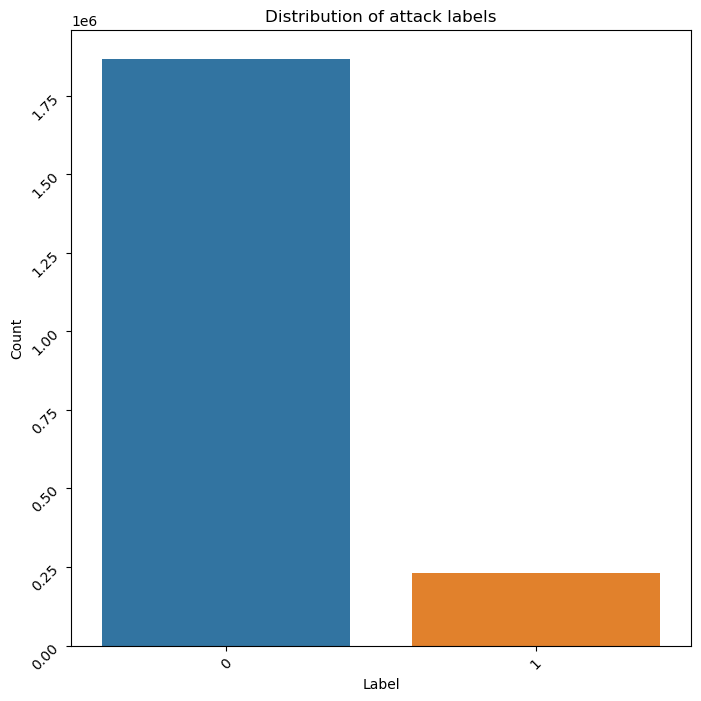

In [64]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x='Label',y='counts',data=traindf.groupby('Label').size().reset_index(name='counts'))
ax.set_title('Distribution of attack labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [67]:
lstm_output_size = 70

cnn = Sequential()
cnn.add(tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False))
cnn.add(Convolution1D(64, 3, padding="same",
        activation="relu", input_shape=(45, 1)))
cnn.add(Convolution1D(64, 3, padding="same", activation="relu"))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(Convolution1D(128, 3, padding="same", activation="relu"))
cnn.add(Convolution1D(128, 3, padding="same", activation="relu"))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(LSTM(lstm_output_size))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="sigmoid"))

In [68]:
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [69]:
checkpointer = callbacks.ModelCheckpoint(
    filepath="./content/results/cnn3results/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='accuracy', mode='max')
csv_logger = CSVLogger(
    './content/results/cnn3results/cnntrainanalysis1.csv', separator=',', append=True)

In [77]:
for column in traindf.columns:
    try:
        if traindf[column].dtype == type(object):
            le = LabelEncoder()
            traindf[column] = traindf[column].astype(str)
            traindf[column] = traindf[column].str.replace(".", "", regex=True)
            traindf[column] = le.fit_transform(traindf[column])
    except Exception as e:
        print(e)
        print(column)

C = traindf.iloc[1:, 43]
T = traindf.iloc[1:, 1:43]
scaler = Normalizer().fit(T)
trainT = scaler.transform(T)
y_train = np.array(C)
X_train = np.reshape(trainT, (trainT.shape[0], trainT.shape[1], 1))

In [78]:
for column in testdf.columns:
    try:
        if testdf[column].dtype == type(object):
            le = LabelEncoder()
            testdf[column] = testdf[column].astype(str)
            testdf[column] = testdf[column].str.replace(".", "", regex=True)
            testdf[column] = le.fit_transform(testdf[column])
    except Exception as e:
        print(e)
        print(column)
C = testdf.iloc[1:, 43]
T = testdf.iloc[1:, 1:43]
scaler = Normalizer().fit(T)
testT = scaler.transform(T)
y_test = np.array(C)
X_test = np.reshape(testT, (testT.shape[0], testT.shape[1], 1))

In [79]:
cnn.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[checkpointer, csv_logger, callbacks.EarlyStopping(monitor='accuracy', patience=3)])
cnn.save("./content/results/cnn3results/cnn_model.hdf5")

  297/65625 [..............................] - ETA: 24:16 - loss: 0.2364 - accuracy: 0.8964

KeyboardInterrupt: 